In [0]:
# Import packages
import os, re, string, time
import pandas as pd
import numpy as np
from torchtext import data
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from torchtext.vocab import GloVe
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
# Mount google drive to colab to import data
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('gdrive/My Drive/Colab Notebooks/Yelp')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'Copy of One_hot_yelp.ipynb'
 One_hot_yelp.ipynb
 Performance.gsheet
 Running_copy_binary.ipynb
 yelp_academic_dataset_review_50k.json
 yelp_academic_dataset_review.json
 yelp_academic_dataset_review_small.json
 yelp_academic_dataset_review_very_small.json
 Yelp_binary.ipynb
 Yelp_linear_regression.ipynb
 Yelp_ordinal_approach.ipynb
 Yelp_rescale.ipynb


In [0]:
# Load data
df = pd.read_json(path_or_buf='yelp_academic_dataset_review.json',lines=True)

# Keep only reviews and score
df = df[['stars','text']]

# Print size of data
print('Number of reviews before trimming:', len(df))

# Limit size of data set (to avoid awkward ends)
limit = 229000
df = df.iloc[0:limit]
print('Number of reviews after trimming:', len(df))


Number of reviews before trimming: 229907
Number of reviews after trimming: 229000


In [0]:
# Preprocess reviews
def preprocess_text(sen):
  #Make all lower case
  sen = sen.lower()

  # Remove digits
  sen = re.sub(r'\d+', '', sen)

  # Remove punctuation
  sen = sen.translate(str.maketrans('', '', string.punctuation))

  # Remove newlines
  sen = re.sub(r'\n', ' ', sen)

  return sen
  
X = []
sentences = list(df['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

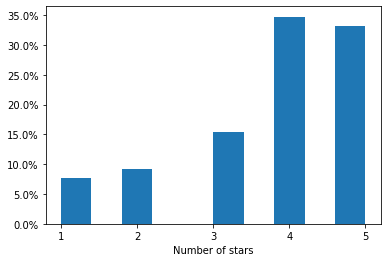

In [0]:
# Examine ratings and make into one-hot encoding
scores = np.array(df['stars'])

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter

plt.hist(scores, weights=np.ones(len(scores)) / len(scores))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Number of stars")
plt.xticks((1,2,3,4,5) ,('1', '2', '3', '4', '5'))
plt.show()

#One-hot encoding
scores = scores - 1
from keras.utils import to_categorical
scores = to_categorical(scores)

In [0]:
# Split data into train, test and validation
X_train, X_test, y_train, y_test = train_test_split(X, scores, test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Size of train data: {}".format(len(X_train)))
print("Size of validation data: {}".format(len(X_val)))
print("Size of test data: {}".format(len(X_test)))

Size of train data: 183200
Size of validation data: 22900
Size of test data: 22900


In [0]:
# Tokenize reviews
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
print('Vocab size is', vocab_size) # But we only keep then amount specified in num_words

Vocab size is 186446


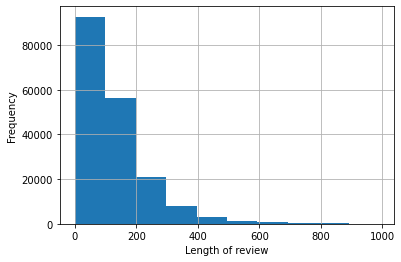

count    183200.000000
mean        127.096239
std         110.992203
min           0.000000
25%          52.000000
50%          97.000000
75%         168.000000
max         990.000000
dtype: float64

In [0]:
# Check the lengths of reviews (in words)
reviews_len = [len(x) for x in X_train]
pd.Series(reviews_len).hist()
plt.xlabel("Length of review")
plt.ylabel("Frequency")
plt.show()

pd.Series(reviews_len).describe()

In [0]:
# Padding
maxlen = 200

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='pre', maxlen=maxlen)

In [0]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# Dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
# Let's have a look at the input and target
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
#print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[   0,    0,    0,  ...,  658,  209,  258],
        [   0,    0,    0,  ...,    9,    5,   51],
        [   0,    0,    0,  ..., 1819,    2,  345],
        ...,
        [   0,    0,    0,  ..., 5503,    7, 9447],
        [7134,    2,    3,  ..., 8062,    5,   37],
        [   0,    0,    0,  ...,  779,   72, 1642]], dtype=torch.int32)

Sample label size:  torch.Size([50, 5])


In [0]:
class Net(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0):
        super(Net, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        x = x.cuda()
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size,maxlen,-1)
        
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden


In [0]:
# Hyperparameters and initialization of model
output_size = 5
embedding_dim = 512
hidden_dim = 512
n_layers = 1
net = Net(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

Net(
  (embedding): Embedding(186446, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (sig): Sigmoid()
)


1000 Train
2000 Train
3000 Train
Epoch:  1
Time elapsed: 3.9256838083267214 minutes
training loss: 0.007059185091471178
validation loss: 0.014029917438477929
1000 Train
2000 Train
3000 Train
Epoch:  2
Time elapsed: 7.863744513193766 minutes
training loss: 0.006255598050912264
validation loss: 0.006431848383366281
1000 Train
2000 Train
3000 Train
Epoch:  3
Time elapsed: 11.806260935465495 minutes
training loss: 0.006032064582941053
validation loss: 0.006299225579963501
1000 Train
2000 Train
3000 Train
Epoch:  4
Time elapsed: 15.75526260137558 minutes
training loss: 0.0058689390787423695
validation loss: 0.006244223345575374
1000 Train
2000 Train
3000 Train
Epoch:  5
Time elapsed: 19.71751786470413 minutes
training loss: 0.005716235090909306
validation loss: 0.006126466646595293
1000 Train
2000 Train
3000 Train
Epoch:  6
Time elapsed: 23.63071174621582 minutes
training loss: 0.005569046550881785
validation loss: 0.006056348633948372
1000 Train
2000 Train
3000 Train
Epoch:  7
Time elapsed

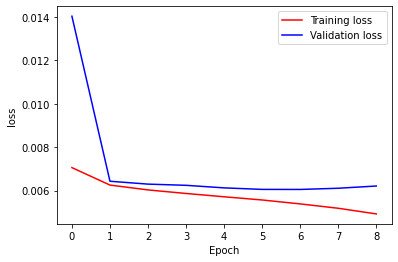

In [0]:
# loss and optimization functions
lr=0.0005

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

# Add learning rate decay
#scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# training params
epochs = 9 # 3-4 is approx where I noticed the validation loss stop decreasing

print_every = 1000
clip=5 # gradient clipping

train_on_gpu = torch.cuda.is_available()
# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

# Track loss
training_loss, validation_loss = [], []
loss_list = []

start_time = time.time()
net.train()
# train for some number of epochs
for e in range(epochs):

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0

    # For validation set
    val_h = net.init_hidden(batch_size)
    val_losses = []
    net.eval()
    for inputs, labels in valid_loader:

        # Creating new variables for the hidden state
        val_h = tuple([each.data for each in val_h])

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        inputs = inputs.type(torch.LongTensor)
        output, val_h = net(inputs, val_h)

        val_loss = criterion(output.squeeze(), labels.float())

        epoch_validation_loss += val_loss.detach().cpu().data.numpy()
    
    net.train()

    # initialize hidden state
    h = net.init_hidden(batch_size)

    # For each review in training set
    counter = 0
    for inputs, labels in train_loader:
        counter += 1
        if counter % print_every == 0:
            print(counter,"Train")

        if(train_on_gpu):
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Creating new variables for the hidden state
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        #Save loss
        epoch_training_loss += loss.detach().cpu().data.numpy()

    print('Epoch: ', e+1)
    print('Time elapsed:', (time.time() - start_time)/60, 'minutes')
    print('training loss:', epoch_training_loss / len(train_data)) # Divided by number of batches
    print('validation loss:', epoch_validation_loss / len(valid_data))

    scheduler.step(val_loss)

    # Save loss for plot
    training_loss.append(epoch_training_loss / len(train_data))
    validation_loss.append(epoch_validation_loss / len(valid_data))

# Plot training and validation loss of training and validation batches
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('loss')
plt.show()

In [0]:
# Get test data loss and accuracy
from sklearn.metrics import accuracy_score

test_losses = [] # track loss
pred_list = []
correct_list = []

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output to rating
    output_array = output.cpu().data.numpy()
    pred = np.argmax(output_array, axis=1) + 1 # rounds to the nearest integer
    pred_list = np.concatenate((pred_list, pred))
    
    # compare predictions to true label
    label_array = labels.cpu().data.numpy()
    correct = np.argmax(label_array, axis=1) + 1# rounds to the nearest integer
    correct_list = np.concatenate((correct_list, correct))

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = accuracy_score(correct_list,pred_list)
print("Test accuracy: {:.3f}".format(test_acc))

# accuracy when tolerating a difference of 1
diff = correct_list - pred_list
test_acc_oneoff = sum(np.absolute(diff) < 2) / len(diff)
print("Test accuracy: {:.3f}".format(test_acc_oneoff))

Test loss: 0.306
Test accuracy: 0.617
Test accuracy: 0.958


In [0]:
# Test on custom reviews
test_review = 'If you are looking for food poisoning this is the perfect place to be'

test_review = preprocess_text(test_review)
test_review = tokenizer.texts_to_sequences([test_review])
test_review = pad_sequences(test_review, padding='pre', maxlen=maxlen)

feature_tensor = torch.tensor(test_review).to(torch.int64)

batch_size = feature_tensor.size(0)

# initialize hidden state
h = net.init_hidden(batch_size)
net.eval()

h = tuple([each.data for each in h])

if(train_on_gpu):
    inputs = feature_tensor.cuda()
    
# get the output from the model
output, h = net(inputs, h)

output_array = output.cpu().data.numpy()
pred = np.argmax(output_array, axis=1) + 1 # rounds to the nearest integer

print('Predicted rating:', pred)

Predicted rating: [5]
